# DAGMM Example
- In this example, anomaly scores of Mixture of Gaussian sample with 2 artificial "Outlier" are calculated.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from model import DAGMM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Generate sample data
- Generate random samples from Mixture of Gaussian
- To check validity of logic, 2 aritificial "Outliers" is mixed to them.

In [4]:
data, _ = make_blobs(n_samples=1000, n_features=5, centers=5, random_state=123)

In [5]:
data[300] = [-1, -1, -1, -1, -1]
data[500] = [ 1,  0,  1,  1,  1]
ano_index = [300, 500]

### Scatter plot
Red Points are mixed "Outliers"

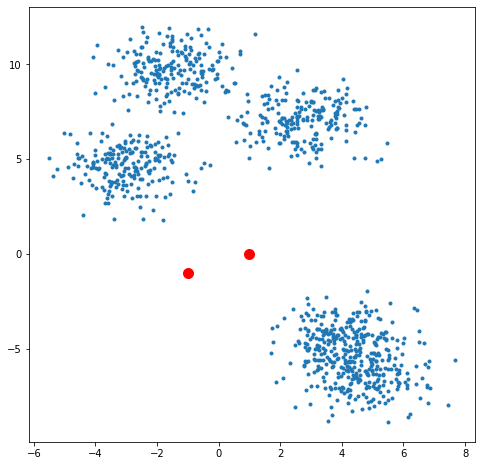

In [6]:
plt.figure(figsize=[8,8])
plt.plot(data[:,0], data[:,1], ".")
plt.plot(data[ano_index,0], data[ano_index,1], "o", c="r", markersize=10)

In [7]:
ss = StandardScaler()
data_normalized = ss.fit_transform(data)

## DAGMM

In [8]:
model = DAGMM(
    input_size=data.shape[1], 
    comp_hiddens=[16, 8, 1], comp_activation=torch.tanh,
    est_hiddens=[8, 4], est_activation=torch.tanh, est_dropout_rate=0.25,
    n_epoch=1000, learning_rate=1e-4)
print(model)

DAGMM(
  (compressor): CompressionNetwork(
    (_reconstruction_loss): MSELoss()
    (encoder): ModuleList(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=8, bias=True)
      (2): Linear(in_features=8, out_features=1, bias=True)
    )
    (decoder): ModuleList(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=5, bias=True)
    )
  )
  (estimator): EstimationNetwork(
    (dropout): Dropout(p=0.25, inplace=False)
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (gmm): GMM()
)


In [9]:
model.fit(data_normalized)

epoch 100/1000 : loss = 171.633
epoch 200/1000 : loss = 65.020
epoch 300/1000 : loss = 27.763
epoch 400/1000 : loss = 14.485
epoch 500/1000 : loss = 9.446
epoch 600/1000 : loss = 7.893
epoch 700/1000 : loss = 7.958
epoch 800/1000 : loss = 9.180
epoch 900/1000 : loss = 11.544
epoch 1000/1000 : loss = 15.328


In [10]:
energy = model.predict(data_normalized)

Text(0, 0.5, 'Number of Sample(s)')

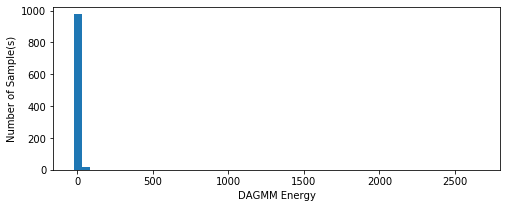

In [11]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

Text(0, 0.5, 'Energy')

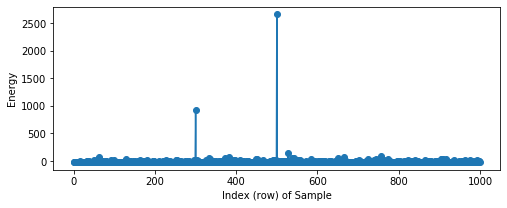

In [12]:
plt.figure(figsize=[8,3])
plt.plot(energy, "o-")
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")

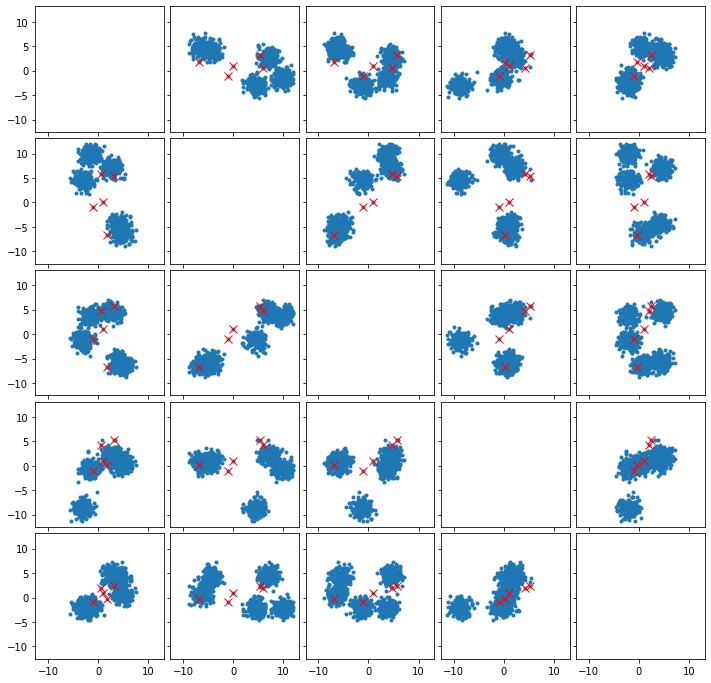

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[12,12], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[:,col], data[:,row], ".")
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 99.5)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", markersize=8)